MACHINE LEARNING FINAL EXAM
Name: Felicia Audrey Tanujaya  

# Case: Liver Cirrhois Stage Prediction

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [ ]:
df= pd.read_csv('1A.tsv',sep='\t')
df.head()

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


## Part A Exploratory Data Analysis (+ Data preparation)

In [ ]:
#Check number of rows
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT                       312 non-null    float64

,ID,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin
count,418.000000,418.000000,80.000000,418.000000,310.000000,312.000000,312.000000,418.000000,407.000000,416.000000
mean,209.500000,3.220813,358.662500,3.497440,97.648387,1982.655769,122.556346,83.803828,257.024570,10.731731
std,120.810458,4.407506,230.414099,0.424972,85.613920,2140.388824,56.699525,79.603693,98.325585,1.022000
min,1.000000,0.300000,149.000000,1.960000,4.000000,289.000000,26.350000,-1.000000,62.000000,9.000000
25%,105.250000,0.800000,236.000000,3.242500,41.250000,871.500000,80.600000,-1.000000,188.500000,10.000000
50%,209.500000,1.400000,284.500000,3.530000,73.000000,1259.000000,114.700000,85.000000,251.000000,10.600000
75%,313.750000,3.400000,409.500000,3.770000,123.000000,1980.000000,151.900000,127.750000,318.000000,11.100000
max,418.000000,28.000000,1480.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000


Anomaly found: Trygliceries level can't be negative.

In [ ]:
df['Tryglicerides'] = df['Tryglicerides'].abs()

In [ ]:
#Create separate list for categorical and numerical columns
categorical = []
numerical = []

for i in df.columns:
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        numerical.append(i)

print(f'Categorical: {categorical}')
print(f'Numerical: {numerical}')

Categorical: ['Registration Date', 'Drug', 'Birth Date', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
Numerical: ['ID', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


In [ ]:
#Feature engineering: deriving patient's age and drop registration date and birth date
df['Registration Date'] = pd.to_datetime(df['Registration Date'])
df['Birth Date'] = pd.to_datetime(df['Birth Date'])
df['Age'] = (df['Registration Date'] - df['Birth Date']).dt.days//365 #assuming the age they start the treatment
df.drop(['Registration Date', 'Birth Date'], axis=1, inplace=True)
categorical.remove('Registration Date')
categorical.remove('Birth Date')
numerical.append('Age')
df.head()

,ID,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,1,D-penicillamine,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,57
1,2,D-penicillamine,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,44
2,3,D-penicillamine,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,67
3,4,D-penicillamine,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4,49
4,5,Placebo,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3,34


In [ ]:
#Dropping identifier column
df.drop('ID', axis=1, inplace=True)
numerical.remove('ID')

In [ ]:
#Checking missing values
df.isnull().sum()

,0
Drug,106
Gender,0
Ascites,106
Hepatomegaly,106
Edema,0
Bilirubin,0
Cholesterol,338
Albumin,0
Copper,108
Alkaline Phospatase (U/L),106


The cholestrol column have a very large amount of missing values (approx 80%) which makes it unreliable and too risky to impute. Therefore, I chose to drop the column. For other features (Drug, Ascites, Hepatomegaly, Copper, Alkaline, SGOT, Platelets, Prothrombin) I chose to do median imputation for numerical columns, and mode imputation for categorical. The reason behind this decision is tto avoid data loss. Lastly, for the missing values in Stage (target var) I dropped the nulls directly to maintain data integrity.

In [ ]:
categorical.remove('Stage')
print(numerical)
print(categorical)

['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age']
['Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema']


In [ ]:
#Handling missing values
#Drop method for cholestrol
df.drop('Cholesterol', axis=1, inplace=True)
numerical.remove('Cholesterol')
#Drop NA for target column
df.dropna(subset=['Stage'], inplace=True)
#Median imputation for numerical columns
for col in numerical:
    median_val = df[col].median()
    df.fillna({col:median_val}, inplace=True)
#Mode imputation for categorical columns
for col in categorical:
  mode_val = df[col].mode()[0]
  df.fillna({col:mode_val}, inplace=True)

In [ ]:
df.isnull().sum()

,0
Drug,0
Gender,0
Ascites,0
Hepatomegaly,0
Edema,0
Bilirubin,0
Albumin,0
Copper,0
Alkaline Phospatase (U/L),0
SGOT,0


In [ ]:
#Checking for duplicates
df.duplicated().sum()

0

In [ ]:
#Check for consistency
for col in categorical:
    print(f"Unique vals in {col}: {df[col].unique()}")
print(f"Unique vals in Stage: {df['Stage'].unique()}")

Unique vals in Drug: ['D-penicillamine' 'Placebo' 'placebo' 'lacebo' 'd-penicillamine']
Unique vals in Gender: ['F' 'M']
Unique vals in Ascites: ['Y' 'N']
Unique vals in Hepatomegaly: ['Y' 'N']
Unique vals in Edema: ['Y' 'N' 'S']
Unique vals in Stage: ['Stage4' 'stage_3' 'Stage 2' 'Stage 1']


In [ ]:
#Standardizing
df['Drug'] = df['Drug'].replace({'d-penicillamine': 'D-penicillamine', 'placebo': 'Placebo', 'lacebo': 'Placebo'})
df['Stage'] = df['Stage'].replace({'stage_3': 'Stage 3', 'Stage4': 'Stage 4'})

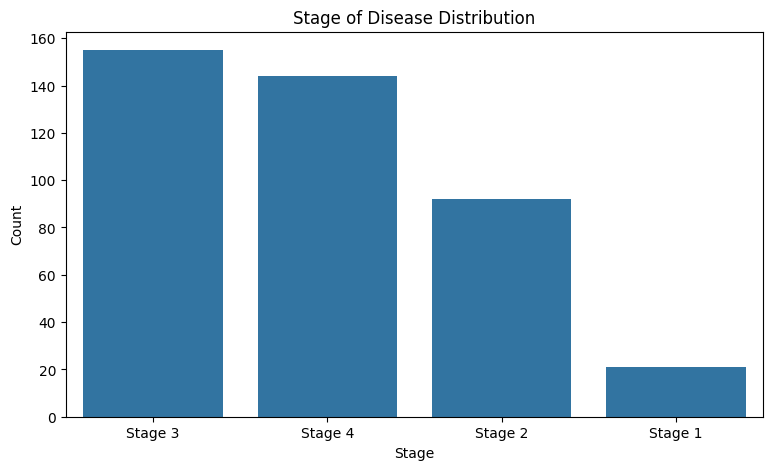

In [ ]:
#Check the distribution of target variable in the dataset
#Visualize the target column y
plt.figure(figsize=(9, 5))
sns.countplot(x='Stage', data=df, order=df['Stage'].value_counts().index)
plt.xlabel('Stage')
plt.ylabel('Count')
plt.title('Stage of Disease Distribution')
plt.show()

The bar chart above shows a class imbalance between the target classes in the dataset, where stage 3 stands as the majority class, followed by stage 4 and stage 2, and stage 1 as minority class. This may affect the model performance especially in minority class and should be handled with resampling later on.

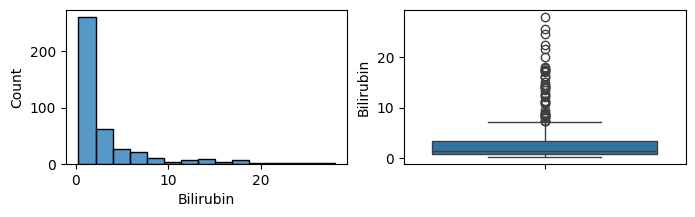

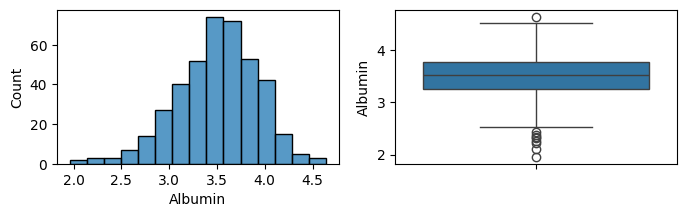

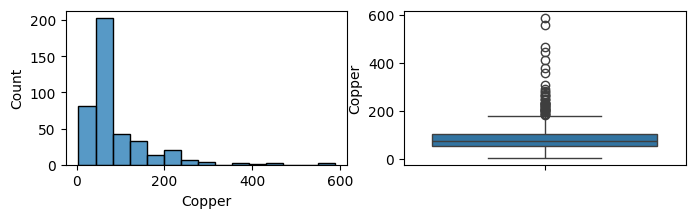

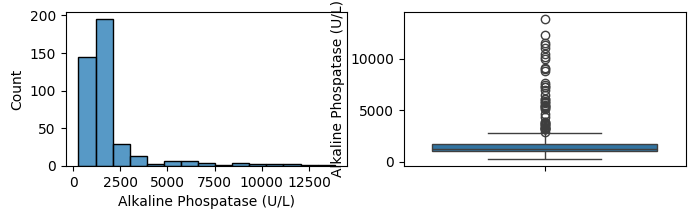

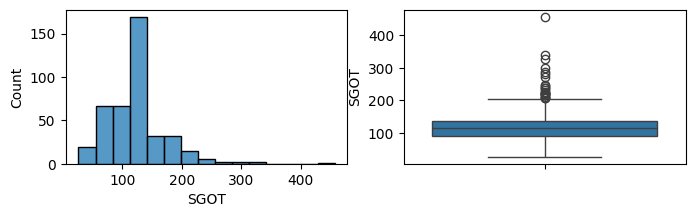

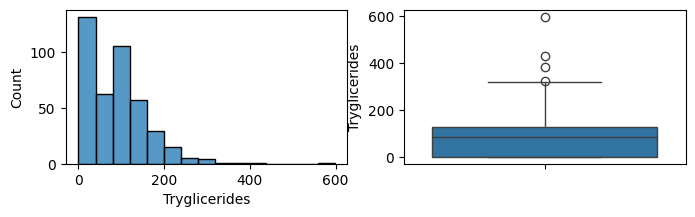

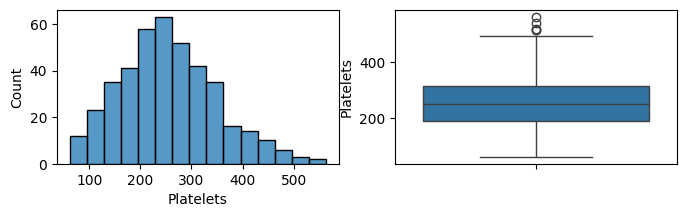

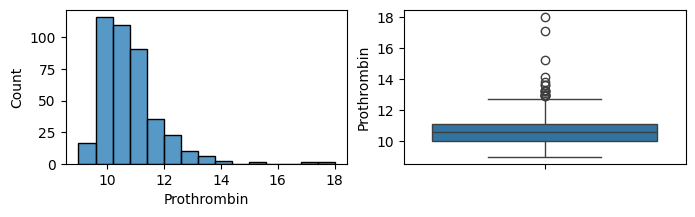

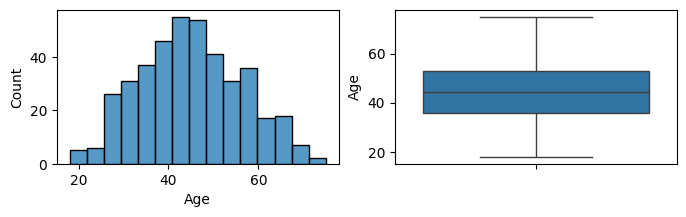

In [ ]:
#Check distribution of all features
def check_dist(df, column):
    for i in column:
        plt.figure(figsize=(8,2))
        plt.subplot(1,2,1)
        sns.histplot(df[i], bins=15)

        plt.subplot(1,2,2)
        sns.boxplot(y=df[i])
        plt.show()

check_dist(df[numerical], numerical)

Some of the numerical features have a few extreme outliers and skewed distribution (especially Billirubin, copper, alkaline, albumine and prothrombin). However after some further research I found that the outliers still make sense thus the decision to retain it. For instance, high bilirubin level, high copper in urine, high alkaline, high SGOT, and low albumin may indicate liver disease, which will be explored more in next visualizations.

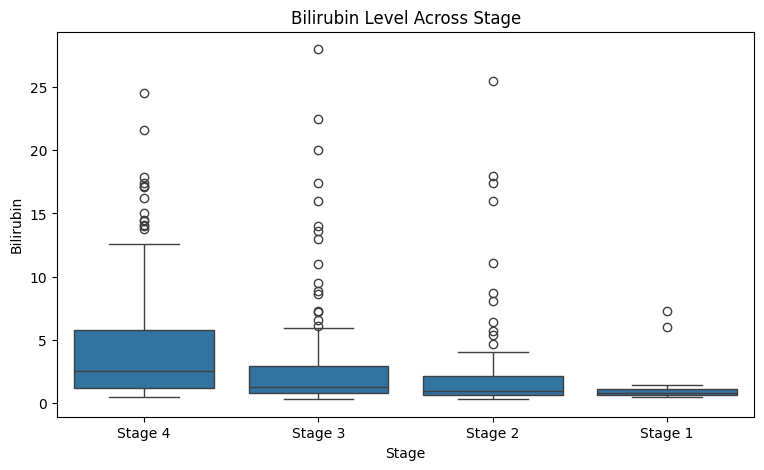

In [ ]:
#Bilirubin level across stages
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x='Stage', y='Bilirubin')
plt.title('Bilirubin Level Across Stage')
plt.xlabel('Stage')
plt.ylabel('Bilirubin')
plt.show()

Bilirubin level tend to be higher in later stage of cirrhois as seen by the increasing median from stage 1 to stage 4. This means that bilirubin might be a significant feature to predict cirrhois stage.

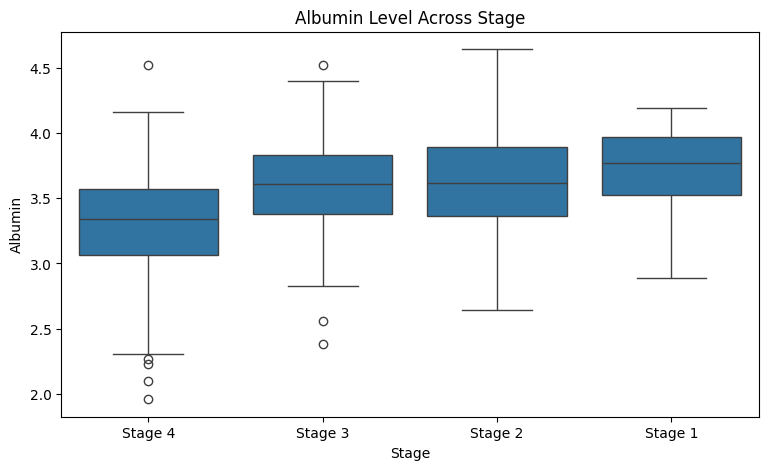

In [ ]:
#Albumin across stages
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x='Stage', y='Albumin')
plt.title('Albumin Level Across Stage')
plt.xlabel('Stage')
plt.ylabel('Albumin')
plt.show()

The chart above further support the hypothesis that "lower albumine might indicate liver disease". It shows the trend of albumine level decreasing as the cirrhois stage progress, with stage 4 have the lowest median amongst the other classes.

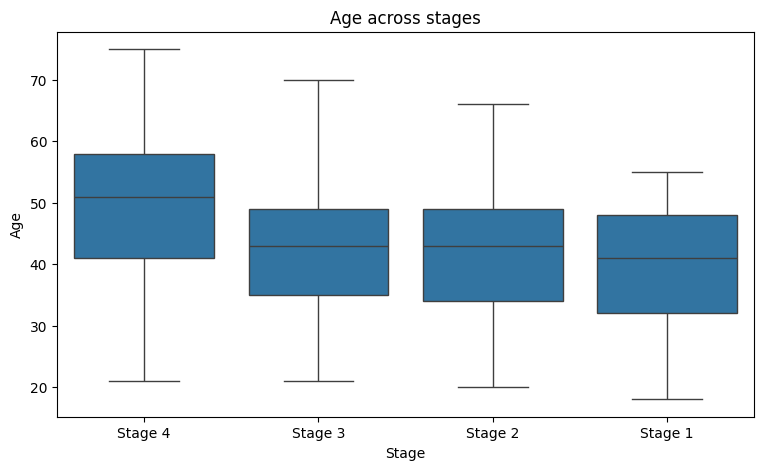

In [ ]:
#Age across stages
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x='Stage', y='Age')
plt.title('Age across stages')
plt.xlabel('Stage')
plt.ylabel('Age')
plt.show()

We can infer that patients in stage 4 tend to be older, as indicated by the higher median age (around 50 years old) and wider iqr. Contrary to stage 1, 2, and 3 that have lower and more similar median age (around early to mid 40) with narrower distribution

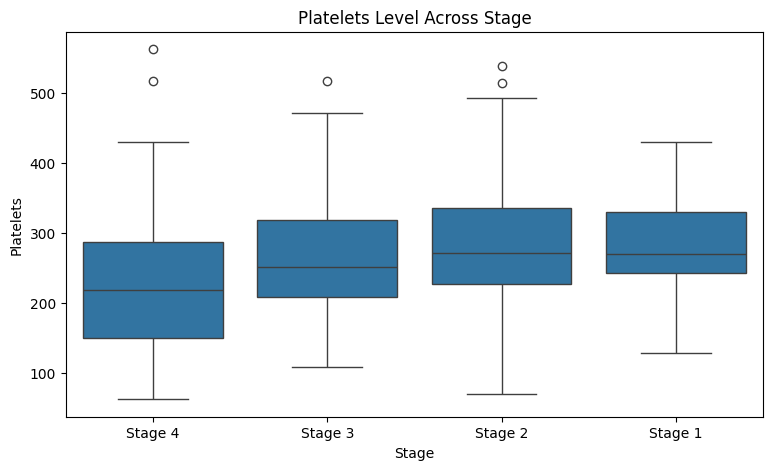

In [ ]:
#Platelets across stages
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x='Stage', y='Platelets')
plt.title('Platelets Level Across Stage')
plt.xlabel('Stage')
plt.ylabel('Platelets')
plt.show()

Similarly, platelets also show a declining trend as the cirrhois stage progress. This is due to the fact that platelets in cirrhosis are often low, which is called thrombocytopenia (common in people with cirrhois).

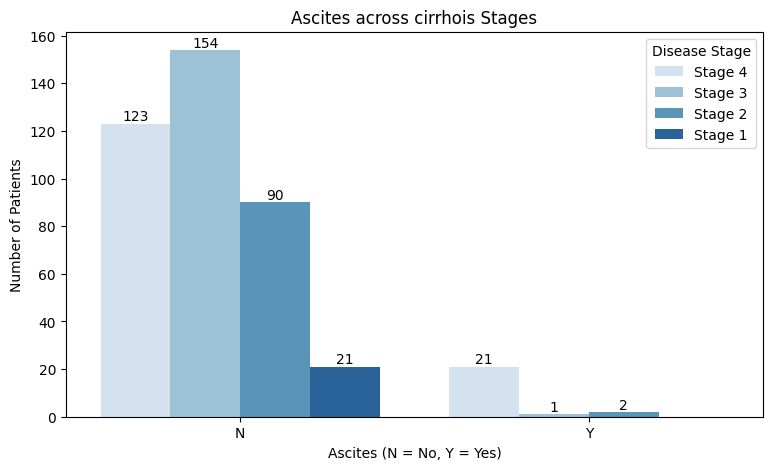

In [ ]:
plt.figure(figsize=(9, 5))
sns.countplot(x='Ascites', hue='Stage', data=df, palette='Blues', order=['N', 'Y'])
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge')
plt.title('Ascites across cirrhois Stages')
plt.xlabel('Ascites (N = No, Y = Yes)')
plt.ylabel('Number of Patients')
plt.legend(title='Disease Stage')
plt.show()


Patients without ascites are more prevalent across all stages and those with ascites (Y) are rare, and most cases are concentrated in the advanced stage which is stage 4.

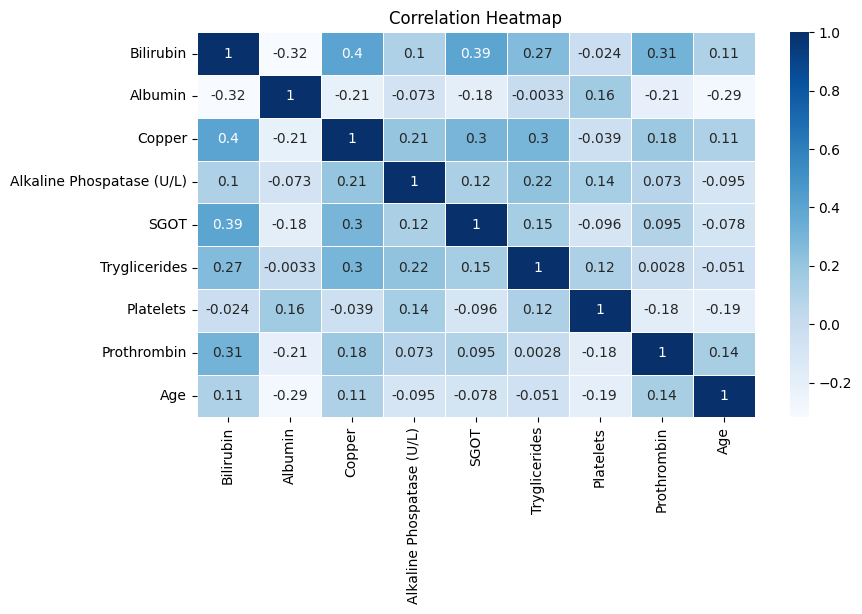

In [ ]:
#Corr heatmap
correlation_matrix = df[numerical].corr()
plt.figure(figsize=(9,5))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

There's a moderate positive correlation between Bilirubin and Copper (0.4) as well as Bilirubin and SGOT (0.39). Albumin negatively correlates with Age (-0.29) and Bilirubin (-0.32), which suggest reduced Albumin levels in older individuals or those with high Bilirubin.

In [ ]:
df['Stage']

,Stage
0,Stage 4
1,Stage 3
2,Stage 4
3,Stage 4
4,Stage 3
...,...
413,Stage 3
414,Stage 4
415,Stage 3
416,Stage 3


In [ ]:
#Ordinal encoding on target variable
stage_order = [['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']]
ordinalenc = OrdinalEncoder(categories=stage_order)
df['Stage'] = ordinalenc.fit_transform(df[['Stage']])
print(df['Stage'].unique())


[3. 2. 1. 0.]


In [ ]:
#Splitting
x = df.drop(columns=['Stage'])
y = df['Stage']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
#Scaling
robust = RobustScaler()
x_train[numerical] = robust.fit_transform(x_train[numerical])
x_test[numerical] = robust.transform(x_test[numerical])
x_train.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age
5,Placebo,F,N,Y,N,-0.230769,0.803571,-0.500000,-0.459184,-0.466667,-0.189394,0.000000,0.363636,0.8750
45,D-penicillamine,F,N,Y,N,1.653846,-1.232143,1.913043,15.004373,0.473978,0.583333,2.085271,1.909091,-0.3750
407,D-penicillamine,F,N,Y,S,0.192308,-0.642857,0.000000,0.000000,0.000000,-0.659091,-0.674419,0.090909,0.1875
398,D-penicillamine,F,N,Y,N,2.576923,-1.267857,0.000000,0.000000,0.000000,-0.659091,-0.434109,-0.181818,-0.4375
118,D-penicillamine,F,N,N,N,-0.307692,0.535714,1.217391,-0.459184,-0.366667,0.196970,0.441860,-1.000000,0.4375


In [ ]:
y_train.head()

,Stage
5,2.0
45,2.0
407,2.0
398,1.0
118,2.0


In [ ]:
#Encoding
labelenc = LabelEncoder()
ordinalenc = OrdinalEncoder()
binary = ['Gender', 'Ascites', 'Hepatomegaly', 'Drug']
#Label Encoding for binary cols
for i in df[binary]:
    x_train[i] = labelenc.fit_transform(x_train[i])
    x_test[i] = labelenc.transform(x_test[i])
#Ordinal encoding for Edema
x_train['Edema'] = ordinalenc.fit_transform(x_train[['Edema']])
x_test['Edema'] = ordinalenc.transform(x_test[['Edema']])
x_train.head()
y_train.head()

,Stage
5,2.0
45,2.0
407,2.0
398,1.0
118,2.0


In [ ]:
#Random oversampling -> to handle class imbalance
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
print("result", Counter(y_train))

result Counter({2.0: 127, 1.0: 127, 3.0: 127, 0.0: 127})


## Part B Modelling - Fine Tuning & Part C Evaluation

### Random Forest

In [ ]:
#Random Forest (before fine tuning)
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.19      0.17      0.18        18
         2.0       0.38      0.54      0.44        28
         3.0       0.63      0.55      0.59        31

    accuracy                           0.42        83
   macro avg       0.30      0.31      0.30        83
weighted avg       0.40      0.42      0.41        83

[[ 0  2  4  0]
 [ 0  3 11  4]
 [ 0  7 15  6]
 [ 0  4 10 17]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Hyperparameter tuning
rf_grid = RandomForestClassifier()
rf_param = {
    'max_depth': [5, 10, 20],
    'n_estimators': [50, 80, 100],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}
grid = GridSearchCV(rf_grid, rf_param, cv = 3, scoring='f1_macro', verbose = 1)
rf_grid = grid.fit(x_train, y_train)
print(rf_grid.best_params_)
print(rf_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}
0.7473989834198721


In [ ]:
#Random Forest 2: Fine tuned
print(classification_report(y_test, rf_grid.predict(x_test)))
print(confusion_matrix(y_test, rf_grid.predict(x_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         6
         1.0       0.45      0.50      0.47        18
         2.0       0.51      0.64      0.57        28
         3.0       0.69      0.58      0.63        31

    accuracy                           0.57        83
   macro avg       0.66      0.51      0.54        83
weighted avg       0.60      0.57      0.57        83

[[ 2  2  2  0]
 [ 0  9  6  3]
 [ 0  5 18  5]
 [ 0  4  9 18]]


### XGBoost

In [ ]:
#XGBoost 1 (before finetuned)
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.25      0.28      0.26        18
         2.0       0.50      0.61      0.55        28
         3.0       0.73      0.61      0.67        31

    accuracy                           0.52        83
   macro avg       0.54      0.46      0.48        83
weighted avg       0.54      0.52      0.52        83

[[ 2  3  1  0]
 [ 1  5  9  3]
 [ 0  7 17  4]
 [ 0  5  7 19]]


In [ ]:
#Hyperparameter Tuning XGboost
xgb_grid = XGBClassifier()
xgb_param = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'scale_pos_weight': [1, 3, 5]
    }

grid = GridSearchCV(estimator=xgb_grid, param_grid=xgb_param,cv=3,scoring='f1_macro', verbose=1)
xgb2 = grid.fit(x_train.values, y_train.values)
print(xgb2.best_params_)
print(xgb2.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 1}
0.7265427591298174


## Part C Evaluation

In [ ]:
#XGBoost 2 after fine tuned
y_pred_xgb = xgb2.predict(x_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         6
         1.0       0.30      0.39      0.34        18
         2.0       0.57      0.57      0.57        28
         3.0       0.70      0.68      0.69        31

    accuracy                           0.55        83
   macro avg       0.64      0.49      0.53        83
weighted avg       0.59      0.55      0.56        83

[[ 2  3  1  0]
 [ 0  7  7  4]
 [ 0  7 16  5]
 [ 0  6  4 21]]


In [ ]:
#Random Forest 2: Fine tuned
print(classification_report(y_test, rf_grid.predict(x_test)))
print(confusion_matrix(y_test, rf_grid.predict(x_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         6
         1.0       0.45      0.50      0.47        18
         2.0       0.51      0.64      0.57        28
         3.0       0.69      0.58      0.63        31

    accuracy                           0.57        83
   macro avg       0.66      0.51      0.54        83
weighted avg       0.60      0.57      0.57        83

[[ 2  2  2  0]
 [ 0  9  6  3]
 [ 0  5 18  5]
 [ 0  4  9 18]]


1. Main metric : F1-Score
- There is class imbalance, as seen in the dataset
- Both false positives (FP) and false negatives (FN) have significant consequences in medical prediction such as this cirrhois stage prediction.

2. Evaluation Result
XGBOOST
- Class 0/Stage 1 (F1-score: 0.50)  
Precision: 1.00, all predicted Class 0 cases are correct  
Recall: 0.33, only a third of actual Class 0 cases were detected  
The model avoids FPs but misses many actual data
- Class 1/Stage 2 (F1-score: 0.34)  
Precision: 0.30, only 30% of predicted Class 1 cases are correct  
Recall: 0.39, less than half of actual Class 1 cases were identified.  
The model struggles significantly to distinguish Class 1.   
-Class 2/Stage 3 (F1-score: 0.57)    
Precision: 0.57, more than half of the predicted Class 2 cases are correct.  
Recall: 0.57, the model detects 57% of actual Class 2 cases.  
The model performs moderately well for this class.  
- Class 3 / Stage 4 (F1-score: 0.69)  
Precision: 0.70, most predicted Class 3 cases are correct  
Recall: 0.68, most actual Class 3 cases are succesfully identified
This one's the model's strongest class with a good balance between precision and recall (which is proven on the F1-score)  

**Confusion Matrix**  
- Class 0 is often misclassified as Class 1 and Class 2 which causedg low recall.
- Class 1 is often confused with Class 2 and Class 3  
-  Class 2 is often mistaken for Class 1 and Class 3
- Class 3 is the most accurately predicted class but still confused with Class 2.  

RANDOM FOREST (Best Model)
- Class 0/Stage 1(F1-score: 0.50)  
Precision: 1.00, every prediction of Class 0 is correct.  
Recall: 0.33 , only 33% of actual Class 0 data were detected.  
The model missed most of its actual instances but making no false predictions.
- Class /Stage 2  (F1-score: 0.47)  
Precision: 0.45 almost half Class 1 predictions are correct.  
Recall: 0.50, half of the actual Class 1 predictions are correct.  
The model struggles to distinguish Class 1.
-Class 2 (F1-score: 0.57)  
Precision: 0.51, over half of predicted Class 2 cases are correct.  
Recall: 0.64 The model succesfully identified most of actual Class 2 data .  
The model is moderately effective for Class 2
- Class 3 (F1-score: 0.63)  
Precision: 0.69, most of predicted Class 3 are correct.  
Recall: 0.58, the model identifies a majority of Class 3 data.  
This class is the model's strongest class with a good balance between precision and recall.  

**Confusion Matrix**
- Class 0, the model misses most of its data (often classified as Class 1 and 2).  
- Class 1 and 2 are frequently confused with each other.
- Class 3 is the most reliable but still gets confused with Class 2.


## Part D Features Importance

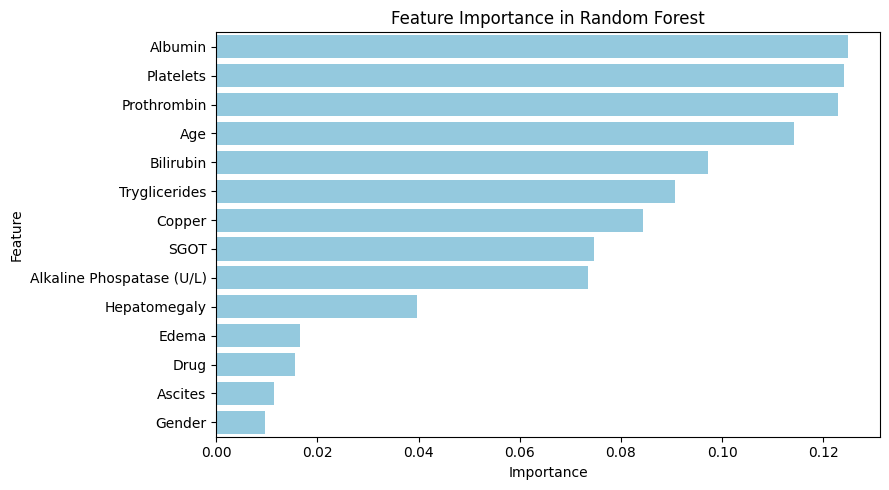

In [ ]:
importance = rf_grid.best_estimator_.feature_importances_
feature_names = x_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(9, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

From the feature importance, we can infer that the most important features in this analysis are Albumin, Platelets, Prothrombin, Age, and Bilirubin, which contribute significantly to predicting the output.

In [ ]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1